### Biblioteki używane w rozwiązaniu zadania

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
from copy import deepcopy

In [37]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce GTX 1070 Ti is available.


# Zadanie 1

Poniżej umieszczamy klasę reprezentującą sieć **PINN**, napisaną na podstawie pliku *PINN.py*. Klasa ta jest wykorzystywana w poleceniach z podpunktów a) i b) tego zadania.

In [2]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Dane jest równanie różniczkowe zwyczajne $\frac{du(x)}{dx} = cos(\omega x)$, którego rozwiązania będziemy szukać z pomocą sieci neuronowej. Wiemy, że analityczna postać rozwiązania tego równania z warunkiem początkowym $u(0)=0$ to $u(x) = \frac{1}{\omega}\sin(\omega x)$.

In [3]:
def f_fun(x, w): # funkcja po prawej stronie równania
    return torch.cos(w * x)

def u_fun(x, w): # analityczne rozwiązanie z warunkiem początkowym u(0) = 0
    return 1.0 / w * torch.sin(w * x)

Poniżej zapisujemy wartości charakterystycznych parametrów sieci neuronowej, których będziemy używać na przestrzeni całego zadania.

In [4]:
domain = [-2 * np.pi, 2 * np.pi]
learning_rate = 0.001
train_steps = 50000
torch.manual_seed(1234) # ustawianie ziarna generacji 

Na podstawie kodu z pliku *PINN.py* przygotowujemy funkcje trenującą sieć neuronową oraz funkcję testującą już wytrenowaną sieć.

In [5]:
def train_NN(omega, hidden_layers, neurons, train_points, train_steps, learning_rate, net = FCN):
    saved_pinns = [] # now we save only last state to show

    pinn = net(1, 1, neurons, hidden_layers)
    t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
    t_residual = torch.linspace(domain[0], domain[1], train_points).view(-1, 1).requires_grad_(True)
    optimiser = torch.optim.Adam(pinn.parameters(), lr = learning_rate)
    
    cos_const = f_fun(t_residual, omega)
    loss_fun = []
    
    for i in range(train_steps + 1):
        if i == train_steps: saved_pinns.append(deepcopy(pinn))
        
        optimiser.zero_grad()

        # Compute initial condition loss
        u_boundary = pinn(t_boundary)
        initial_condition_loss = u_boundary ** 2

        # Compute residual loss
        u_residual = pinn(t_residual)
        dudt = torch.autograd.grad(u_residual, t_residual, torch.ones_like(u_residual),
                                   create_graph = True, retain_graph = True)[0]
        residual_loss = torch.mean((dudt - cos_const) ** 2)

        # Total loss
        loss = initial_condition_loss + residual_loss
        loss_fun.append(loss.detach().squeeze()) # save current loss function value for future analysis

        # Backpropagate joint loss, take optimiser step
        loss.backward(retain_graph = True)
        optimiser.step()

        # Print the loss every 10000 steps
        if i % 10000 == 0:
            print(f'Step {i}, Loss: {loss.item()}')

    return (saved_pinns, loss_fun)

In [6]:
def test_NN(pinn, test_points):
    t_test = torch.linspace(domain[0], domain[1], test_points).view(-1, 1)
    u_test = pinn(t_test)
    return u_test

Teraz przechodzimy do wytrenowania sieci neuronowych w podstawowym wariancie dla rozważanych przypadków - wartości poszczególnych parametrów są opisane w poleceniu zadania.

In [7]:
trained_a, loss_fun_a = train_NN(
    omega = 1.0, hidden_layers = 2, neurons = 16, train_points = 200, 
    train_steps = train_steps, learning_rate = learning_rate
)

result_a = test_NN(pinn = trained_a[0], test_points = 1000)

Step 0, Loss: 0.4695681631565094
Step 10000, Loss: 5.5980194701987784e-06
Step 20000, Loss: 1.33838352667226e-06
Step 30000, Loss: 1.4767160791961942e-06
Step 40000, Loss: 2.0591282918758225e-06
Step 50000, Loss: 1.0904168448178098e-05


In [8]:
trained_b1, loss_fun_b1 = train_NN(
    omega = 15.0, hidden_layers = 2, neurons = 16, train_points = 3000, 
    train_steps = train_steps, learning_rate = learning_rate
)

result_b1 = test_NN(pinn = trained_b1[0], test_points = 5000)

Step 0, Loss: 0.5358588695526123
Step 10000, Loss: 0.5001449584960938
Step 20000, Loss: 0.5001189112663269
Step 30000, Loss: 0.4922640025615692
Step 40000, Loss: 0.3994387984275818
Step 50000, Loss: 0.27573883533477783


In [9]:
trained_b2, loss_fun_b2 = train_NN(
    omega = 15.0, hidden_layers = 4, neurons = 64, train_points = 3000, 
    train_steps = train_steps, learning_rate = learning_rate
)

result_b2 = test_NN(pinn = trained_b2[0], test_points = 5000)

Step 0, Loss: 0.5033383369445801
Step 10000, Loss: 0.5001606941223145
Step 20000, Loss: 0.001638949615880847
Step 30000, Loss: 0.0002916914236266166
Step 40000, Loss: 0.000714688329026103
Step 50000, Loss: 0.0008059698739089072


In [31]:
trained_b3, loss_fun_b3 = train_NN(
    omega = 15.0, hidden_layers = 5, neurons = 128, train_points = 3000, 
    train_steps = train_steps, learning_rate = learning_rate
)

result_b3 = test_NN(pinn = trained_b3[0], test_points = 5000)

Step 0, Loss: 0.508879542350769
Step 10000, Loss: 0.500165581703186
Step 20000, Loss: 0.4981430172920227
Step 30000, Loss: 0.010984288528561592
Step 40000, Loss: 0.004049554467201233
Step 50000, Loss: 0.006045684218406677


Przedstawmy uzyskane wyniki - przybliżenie funkcji $\hat{u}(x)$ oraz wartości funkcji błędu - na wykresie. W tym celu przygotowujemy odpowiednie funkcje.

In [15]:
def plot_result(pinn_result, exact_solution, train_steps, t_test, name, ax = None):   
    if not ax:
        ax = plt
        ax.figure(figsize = (10, 4.5))
        ax.title(f"Pinn prediction result after {train_steps} training steps for {name}")
    else:
        ax.set_title(f"Pinn prediction result after {train_steps} training steps, for {name}") # zakładamy, że ax to subplot

    ax.plot(t_test, pinn_result.detach().numpy(), label = "PINN solution", color = "tab:green", linestyle = "--")
    ax.plot(t_test, exact_solution, label = "Exact solution", color = "tab:grey", alpha = 0.6)
    ax.legend(loc = 'lower right')
    
    if ax is plt: ax.show()

In [16]:
def plot_loss(loss_fun, train_steps, t_test, name, ax = None):
    if not ax:
        ax = plt
        ax.figure(figsize = (10, 4.5))
        ax.title("Loss function of " + name + " vs train step")
    else:
        ax.set_title("Loss function of " + name + " vs train step") # zakładamy, że ax to subplot

    ax.plot(list(range(0, train_steps + 1)), loss_fun, label = "Loss function of " + name, color = "tab:red")
    ax.legend(loc = 'upper right')
    
    if ax is plt: ax.show()

Powyższe funkcje pozwalają kreślić odpowiednie wykresy niezależnie, natomiast poniżej przedstawiamy funkcję, która umożliwia przedstawienie ich w ramach wspólnej "ramki" wykresu.

In [17]:
def plot_both(pinn_result, loss_fun, exact_solution, train_steps, t_test, name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (19, 10.5))
    fig.suptitle(f'PINN Results and Loss Function for {name}')
    
    # Plot PINN prediction result and exact solution on the first subplot (ax1)
    plot_result(pinn_result, exact_solution, train_steps, t_test, ax1)
    
    # Plot loss function on the second subplot (ax2)
    plot_loss(loss_fun, train_steps, t_test, name, ax2)
    
    plt.show()

Poniżej przedstawiamy funkcję do rysowania wykresów funkcji błędu.

In [88]:
def plot_error(pinn_result, exact_solution, train_steps, t_test, name):
    plt.figure(figsize = (10, 4.5))
    plt.title(f"Error function for {name} after {train_steps} training steps")
    
    res = pinn_result.detach()
      
    plt.plot(t_test, np.abs(res - exact_solution), label = "Error function", color = "tab:green")
    plt.legend(loc = 'upper right')
    plt.show()

Przedstawmy najpierw wykresy we wszystkich postaciach dla pierwszego rozważanego przykładu.

---

Przyjmujemy $\omega=1$, 2 warstwy ukryte, 16 neuronów w każdej warstwie, 200 punktów treningowych oraz 1000 punktów testowych.

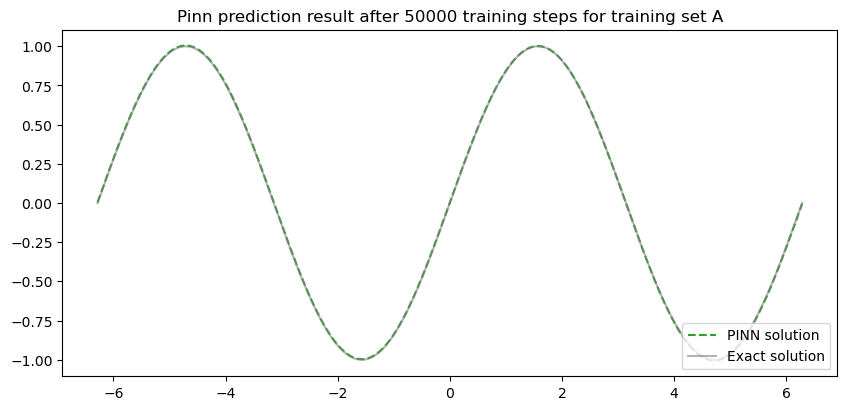

In [19]:
t_test_a = torch.linspace(domain[0], domain[1], 1000).view(-1, 1)
omega_a = 1.0
exact_solution_a = u_fun(t_test_a, omega_a)

plot_result(result_a, exact_solution_a, train_steps, t_test_a, "training set A")

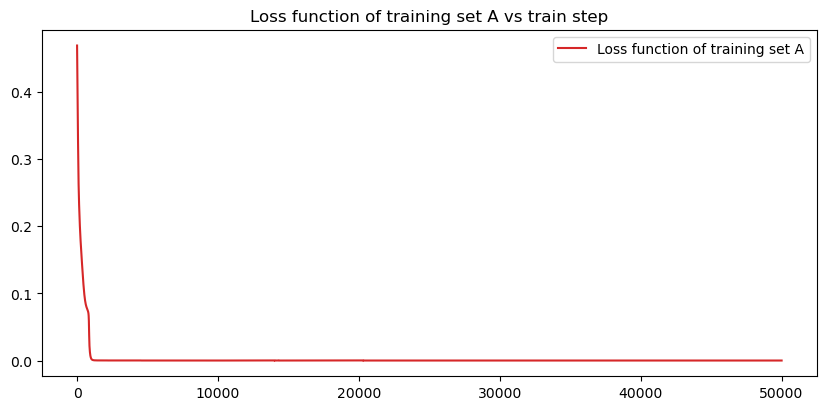

In [ ]:
plot_loss(loss_fun_a, train_steps, t_test_a, "training set A")

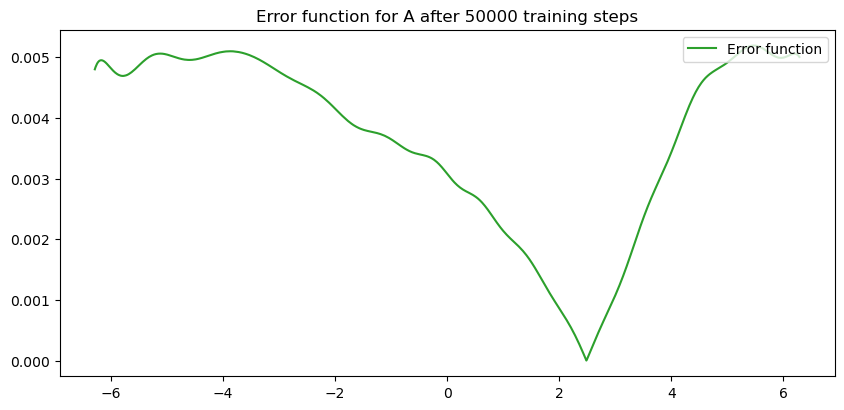

In [89]:
plot_error(result_a, exact_solution_a, train_steps, t_test_a, "A")

Teraz przedstawiamy po kolei wykresy dla pozostałych wariantów.

### Przypadek b.1
Przyjmujemy $\omega=15$, 2 warstwy ukryte, 16 neuronów w każdej warstwie, 3000 punktów treningowych oraz 5000 punktów testowych.

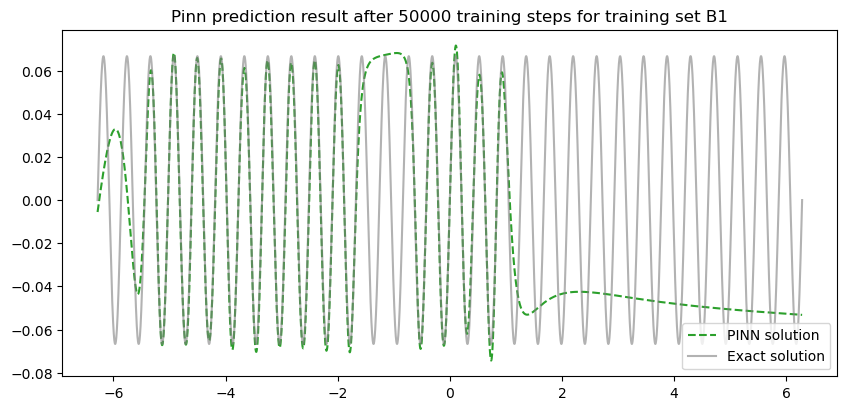

In [47]:
t_test_b1 = torch.linspace(domain[0], domain[1], 5000).view(-1, 1)
omega_b1 = 15.0
exact_solution_b1 = u_fun(t_test_b1, omega_b1)

plot_result(result_b1, exact_solution_b1, train_steps, t_test_b1, "training set B1")

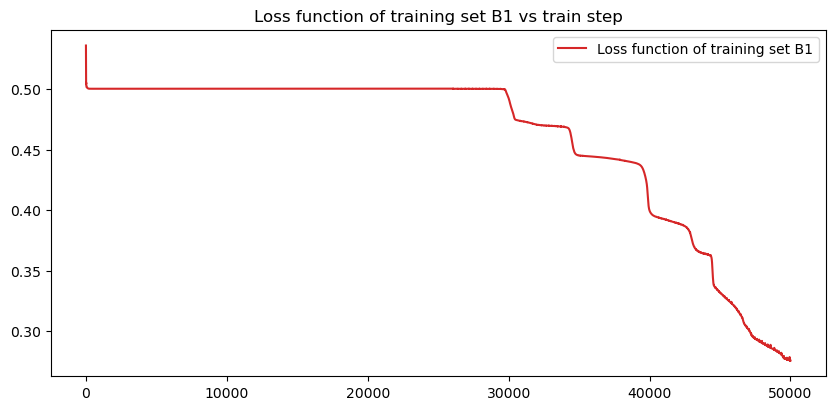

In [48]:
plot_loss(loss_fun_b1, train_steps, t_test_b1, "training set B1")

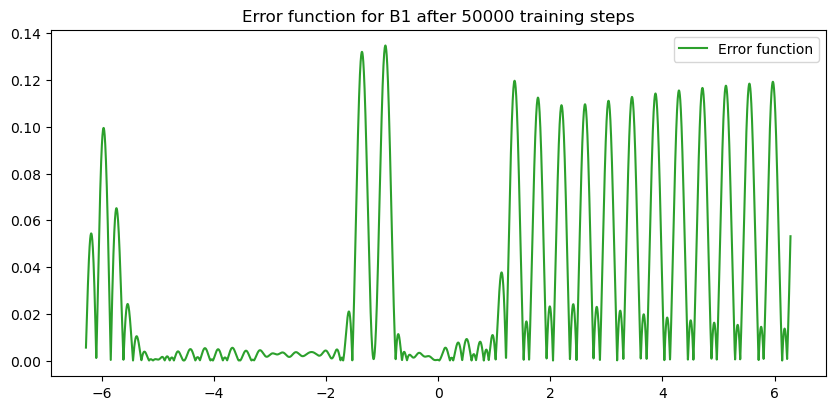

In [90]:
plot_error(result_b1, exact_solution_b1, train_steps, t_test_b1, "B1")

### Przypadek b.2
Przyjmujemy $\omega=15$, 4 warstwy ukryte, 64 neurony w każdej warstwie, 3000 punktów treningowych oraz 5000 punktów testowych.

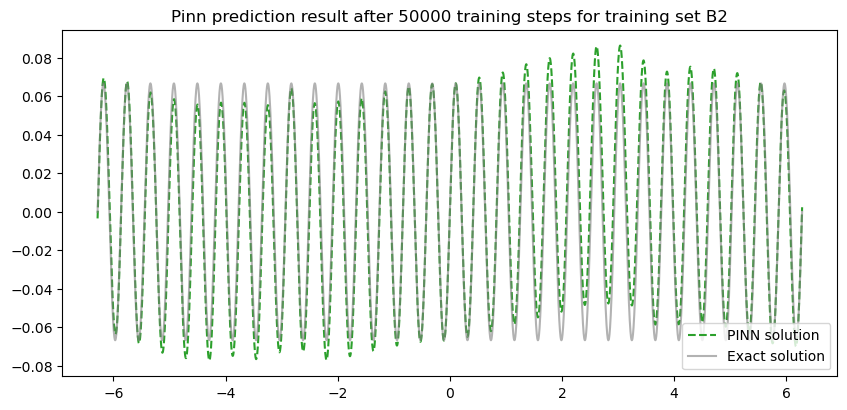

In [51]:
t_test_b2 = torch.linspace(domain[0], domain[1], 5000).view(-1, 1)
omega_b2 = 15.0
exact_solution_b2 = u_fun(t_test_b2, omega_b2)

plot_result(result_b2, exact_solution_b2, train_steps, t_test_b2, "training set B2")

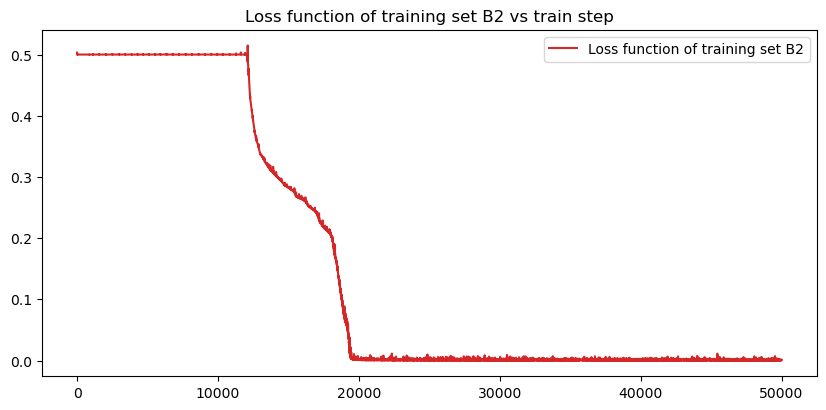

In [52]:
plot_loss(loss_fun_b2, train_steps, t_test_b2, "training set B2")

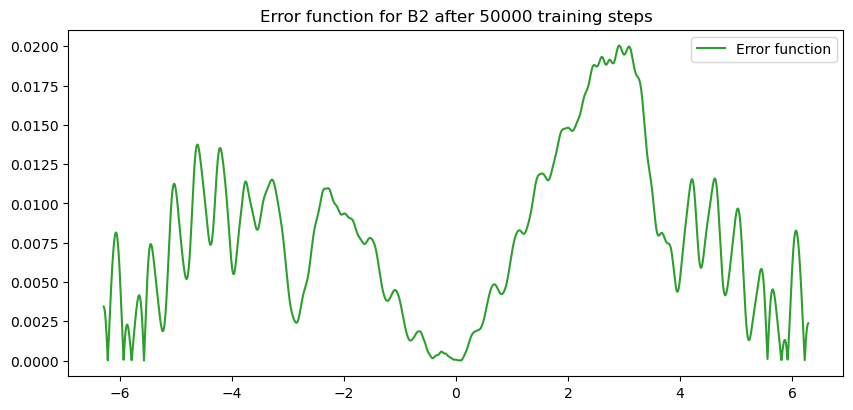

In [91]:
plot_error(result_b2, exact_solution_b2, train_steps, t_test_b2, "B2")

### Przypadek b.3
Przyjmujemy $\omega=15$, 5 warstw ukrytych, 128 neuronów w każdej warstwie, 3000 punktów treningowych oraz 5000 punktów testowych.

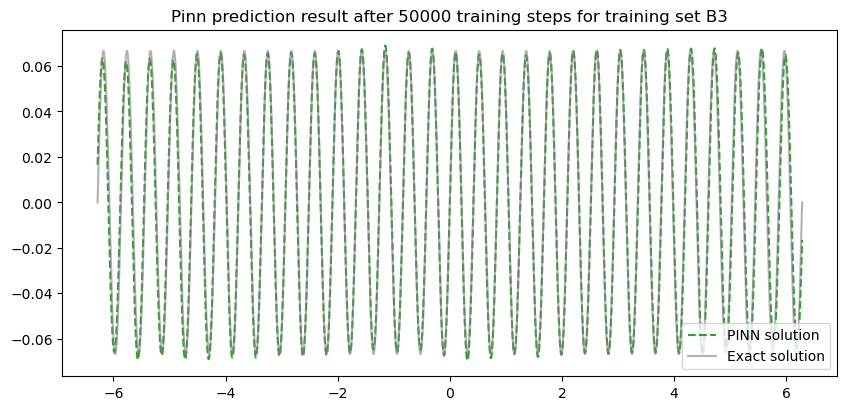

In [56]:
t_test_b3 = torch.linspace(domain[0], domain[1], 5000).view(-1, 1)
omega_b3 = 15.0
exact_solution_b3 = u_fun(t_test_b3, omega_b3)

plot_result(result_b3, exact_solution_b3, train_steps, t_test_b3, "training set B3")

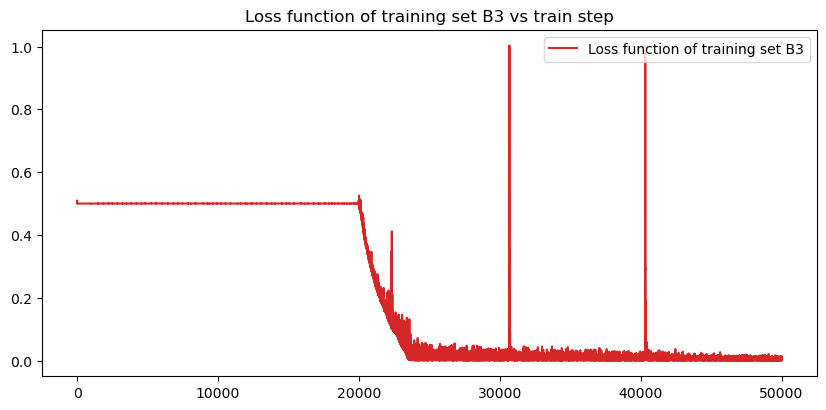

In [57]:
plot_loss(loss_fun_b3, train_steps, t_test_b3, "training set B3")

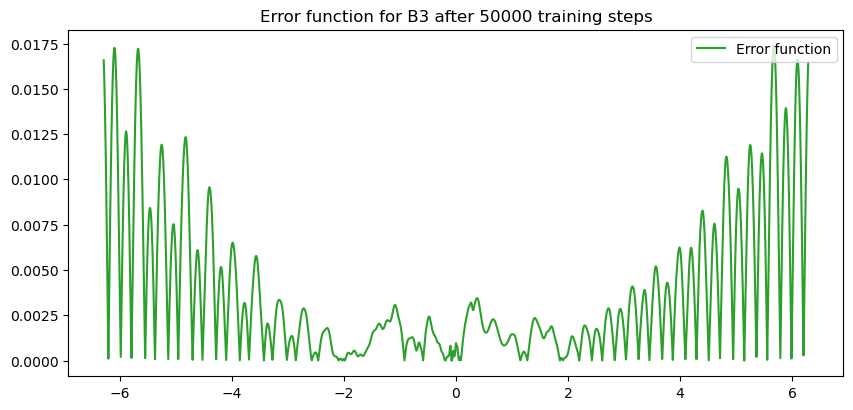

In [92]:
plot_error(result_b3, exact_solution_b3, train_steps, t_test_b3, "B3")

## Porównanie podstawowych sieci PINN ze zmodyfikowanymi wariantami

Do dalszych eksperymentów wybieramy pierwszy przypadek z poprzednich przykładów.

---

Najpierw porównujemy go z rozwiązaniem, w którym rozwiązanie ma postać $\hat{u}(x,\theta)=\textrm{tanh}(\omega x) \cdot NN(x, \theta)$, gdzie $NN$ to oryginalne rozwiązanie. W tym celu przedstawiamy lekko zmodyfikowaną wersję klasy reprezentującej to rozwiązanie.

In [32]:
omega = 1.0 # hiperparametr

class FCN_Ansatz(nn.Module):
    "Defines a fully-connected network in PyTorch with tanh modification"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        x = torch.tanh(omega * x)
        return x

Obliczamy wyniki dla nowej sieci, przyjmując takie same wartości parametrów jak w porównywanym przypadku.

In [33]:
trained_ansatz, loss_fun_ansatz = train_NN(
    omega = 1.0, hidden_layers = 2, neurons = 16, train_points = 200, 
    train_steps = train_steps, learning_rate = learning_rate, net = FCN_Ansatz
)

result_ansatz = test_NN(pinn = trained_ansatz[0], test_points = 1000)

Step 0, Loss: 0.49818581342697144
Step 10000, Loss: 0.12948422133922577
Step 20000, Loss: 0.12939570844173431
Step 30000, Loss: 0.12938715517520905
Step 40000, Loss: 0.12938375771045685
Step 50000, Loss: 0.12938238680362701


Przedstawmy wyniki na wykresach tak jak poprzednio, ale na każdym z nich umieścimy także wykres wyniku dla oryginalnej sieci, żeby można było je łatwo porównać.

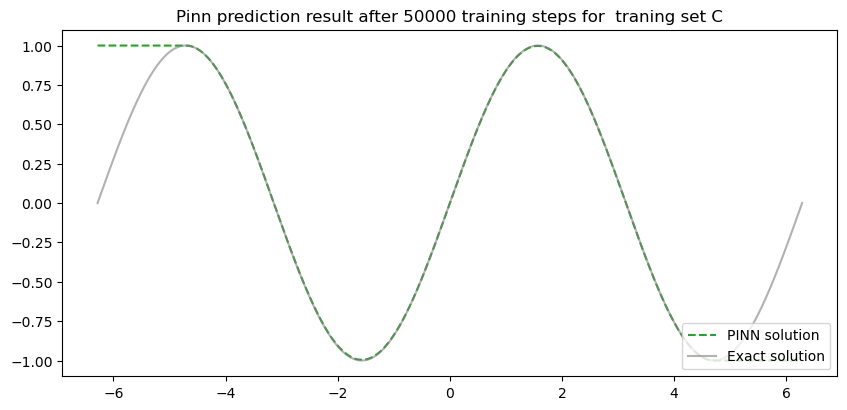

In [34]:
t_test_ansatz = torch.linspace(domain[0], domain[1], 1000).view(-1, 1)
exact_solution_ansatz = u_fun(t_test_ansatz, omega)

plot_result(result_ansatz, exact_solution_ansatz, train_steps, t_test_ansatz, " traning set C")

Poniżej będziemy korzystać z nieco zmodyfikowanych wersji funkcji do przedstawienia wartości funkcji kosztu i funkcji błędu.

In [72]:
def plot_loss2(loss_fun1, loss_fun2, train_steps, t_test, name1, name2, ax = None):
    if not ax:
        ax = plt
        ax.figure(figsize = (10, 4.5))
        ax.title("Loss functions of " + name1 + " and " + name2 + " vs train step")
    else:
        ax.set_title("Loss functions of " + name1 + " and " + name2 + " vs train step") # zakładamy, że ax to subplot

    ax.plot(list(range(0, train_steps + 1)), loss_fun1, label = "Loss function of " + name1, color = "tab:blue")
    ax.plot(list(range(0, train_steps + 1)), loss_fun2, label = "Loss function of " + name2, color = "tab:red")
    ax.legend(loc = 'upper right')
    
    if ax is plt: ax.show()

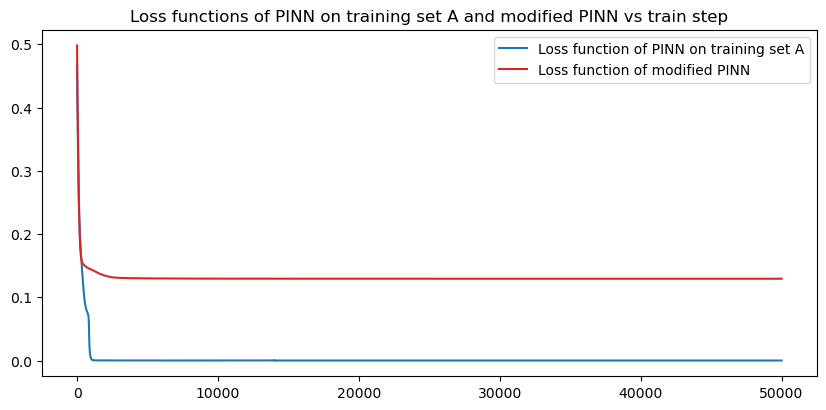

In [81]:
plot_loss2(loss_fun_a, loss_fun_ansatz, train_steps, t_test_ansatz, "PINN on training set A", "modified PINN")

In [79]:
def plot_error2(pinn_result1, pinn_result2,  exact_solution, train_steps, t_test, name1, name2):
    plt.figure(figsize = (10, 4.5))
    plt.title(f"Error functions for {name1} and {name2} prediction after {train_steps} training steps")
    
    res1 = pinn_result1.detach()
    res2 = pinn_result2.detach()
      
    plt.plot(t_test, np.abs(res1 - exact_solution), label = "Error function of " + name1, color = "tab:green")
    plt.plot(t_test, np.abs(res2 - exact_solution), label = "Error function of " + name2, color = "tab:red")
    plt.legend(loc = 'upper right')
    plt.show()

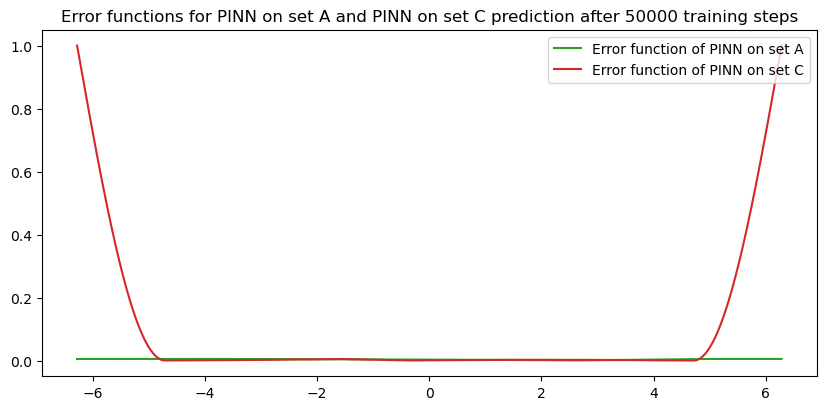

In [82]:
plot_error2(result_a, result_ansatz, exact_solution_ansatz, train_steps, t_test_ansatz, "PINN on set A", "PINN on set C")

Na końcu porównujemy pierwotny wynik z rozwiązaniem, w którym pierwszą warstwę ukrytą zainicjalizowano cechami Fouriera, tzn. 
$$
    \gamma(x)=[\textrm{sin}(2^0\pi x), \textrm{cos}(2^0\pi x),..., \textrm{sin}(2^{L-1}\pi x), \textrm{cos}(2^{L-1}\pi x)].
$$

Klasa reprezentująca sieć neuronową w tym przypadku ulega pewnej modyfikacji, aby uwzględnić inicjowanie pierwszej warstwy cechami Fouriera.

In [11]:
class FCN_Fourier(nn.Module):
    def __init__(self, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        self.L = N_HIDDEN // 2
        activation = nn.Tanh
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) 
                            for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT) 
        
    def forward(self, x):
        result = torch.tensor([])
        for l in range(self.L):
            result = torch.cat((result, torch.sin(2 ** l * torch.pi * x)), 1)
            result = torch.cat((result, torch.cos(2 ** l * torch.pi * x)), 1)
        
        x = self.fch(result)
        x = self.fce(x)

        return x

Obliczamy wyniki dla nowej sieci, przyjmując takie same wartości parametrów jak w porównywanym przypadku.

In [84]:
(fourier_pinn_a, fourier_loss_a) = train_NN(
    omega = 1.0, hidden_layers = 2, neurons = 16, train_points = 200, 
    train_steps = train_steps, learning_rate = learning_rate, net = FCN_Fourier
)

result_fourier_a = test_NN(pinn = fourier_pinn_a[0], test_points = 1000)

Step 0, Loss: 0.5300862193107605
Step 10000, Loss: 2.1113697584951296e-05
Step 20000, Loss: 3.4566833164717536e-06
Step 30000, Loss: 1.2795504744644859e-06
Step 40000, Loss: 6.067084541427903e-07
Step 50000, Loss: 3.6027185501552594e-07


Przedstawmy wyniki na wykresach tak jak poprzednio.

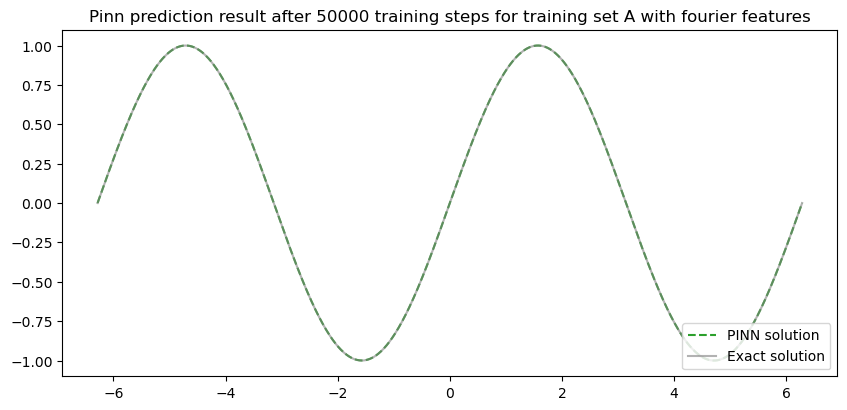

In [85]:
omega = 1.0
t_test_fourier = torch.linspace(domain[0], domain[1], 1000).view(-1, 1)
exact_solution_fourier = u_fun(t_test_fourier, omega)

plot_result(result_fourier_a, exact_solution_fourier, train_steps, t_test_fourier, "training set A with fourier features")

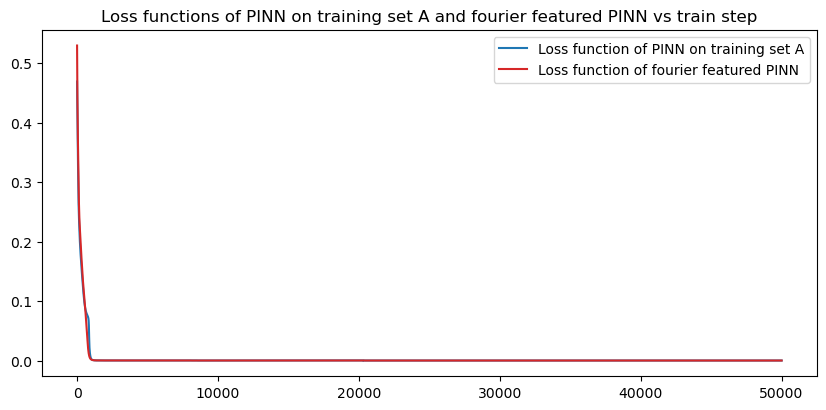

In [86]:
plot_loss2(loss_fun_a, fourier_loss_a, train_steps, t_test_ansatz, "PINN on training set A", "fourier featured PINN")

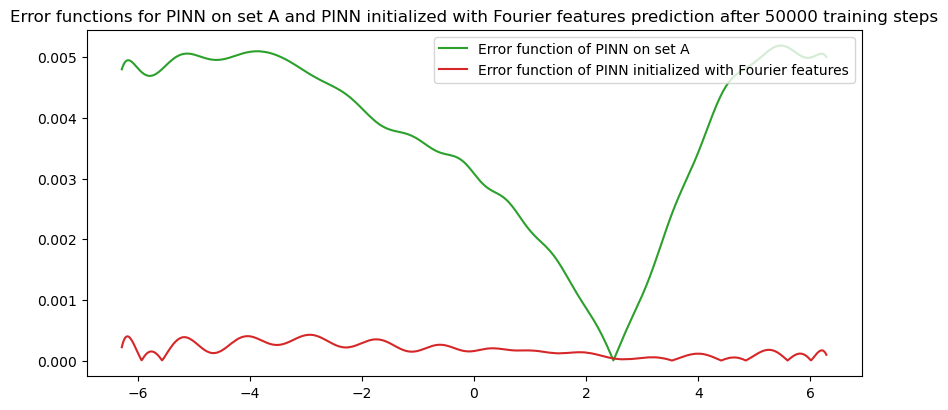

In [87]:
plot_error2(result_a, result_fourier_a, exact_solution_fourier, train_steps, t_test_fourier, 
            "PINN on set A", "PINN initialized with Fourier features")